# **Extract data through Google API**

In [40]:
from call_ListGauges import get_ListGauges

In [41]:
import os
from typing import List, Dict, Any
import json
import pandas as pd
import geopandas as gpd
from shapely import geometry
import requests
import pprint
import datetime
import matplotlib.pyplot as plt

##### **Steps**:
To get the data from the Google Bucket into workable format, we follow:
* Connect with the API
* **Expand this step!** Set-up pipeline which downloads all relevant data per country code
* Format the data into DateTime (y) and features (x)
* Store externally as .csv

##### **Background info -- API**
The API has three basic functions:
* *ListGauges*: Returns a list of supported gauges within a given country (code)
* *GetGaugeModel*: Returns model information of a specific gauge (within a given country, that is)
* *QueryGaugeForecasts*: Returns the forecasts of specific gauge

We'll create a pipeline going through these three functions, taking as input just the target country and outputting a DateTime-indexed .csv with all available forecasts for that country's available gauges. 

##### **(??? -> Maybe this is too much... A format which uses a list of matrices (an implicit tensor) where the matrices are just one gauge might be better. Either way, the metadata is best stored separately in a separate .csv. Choose adequate naming here.)**

For subsequent analysis, see ../analyse_data/

In [42]:
def get_json_file(path : str) -> Dict:
    """
    Get .json file stored elsewhere

    :param path: path to the .json file
    :return: the file as a dictionary
    """
    with open(path, 'r') as f:
        return json.load(f)


path_country_codes = "../../data/country_codes.json"
dict_country_codes = get_json_file(path_country_codes)

In [43]:
# Note: add this folder manually at the pointed path for the script to run
# For the key, ask the owner of the repository or try guessing
path_API_key = "../../data/keys/API_key.txt"

In [44]:
df_gauges_ML = get_ListGauges(dict_country_codes['Mali'], path_API_key)

In [45]:
print(type(df_gauges_ML))
print(len(df_gauges_ML))
print(df_gauges_ML.columns)

<class 'pandas.core.frame.DataFrame'>
16
Index(['siteName', 'source', 'river', 'gaugeId', 'qualityVerified', 'latitude',
       'longitude'],
      dtype='object')


In [46]:
print(df_gauges_ML.head(2))

  siteName source      river           gaugeId  qualityVerified   latitude  \
0           HYBAS  Sankarani  hybas_1120766460             True  11.222917   
1           HYBAS             hybas_1120758950             True  11.427083   

   longitude  
0  -8.485417  
1  -6.581250  


In [47]:
def convert_df_to_gdf(df : pd.DataFrame) -> gpd.GeoDataFrame:
    """
    Convert a DataFrame to a GeoDataFrame by taking the latitude and longitude columns

    :param df: the DataFrame
    :return: the GeoDataFrame
    """
    return gpd.GeoDataFrame(
        df,
        geometry = gpd.points_from_xy(df['longitude'], df['latitude']),
        crs = 'EPSG:4326' # Uniform projection to WGS84
    )


def get_shape_file(file : str) -> gpd.GeoDataFrame:
    """
    Get the shape file for a country

    :param country: the country
    :return: the GeoDataFrame
    """
    try:
        return gpd.read_file(f"../../data/shape_files/{file}")
    except Exception as exc:
        raise Exception(f'Error reading shapefile: {exc}')


def convert_country_code_to_iso_a3(country_code : str) -> str:
    """
    Convert a country code to an ISO A3 code

    :param country_code: the country code
    :return: the ISO A3 code
    """
    return get_json_file("../../data/country_codes_to_ISO_A3.json")[country_code]


def get_country_polygon(country_code : str) -> gpd.GeoDataFrame:
    """
    Get the polygon of a country as a GeoDataFrame

    :param country_code: the country code
    :return: the polygon
    """
    gdf = get_shape_file('ne_110m_admin_0_countries')
    iso_a3 = convert_country_code_to_iso_a3(country_code)

    country_row = gdf[gdf['SOV_A3'] == iso_a3]
    if country_row.empty:
        raise ValueError(f'Country with ISO A3 code {country_code} not found')
    
    return gpd.GeoDataFrame(geometry = [country_row['geometry'].values[0]])


def map_gauge_coordinates_of_country(df : pd.DataFrame, country : str) -> None:
    """
    Map gauge coordinates

    :param df: the DataFrame with the gauges
    :return: the GeoDataFrame
    """
    gdf = convert_df_to_gdf(df)
    shape = get_country_polygon(dict_country_codes[country])

    fig, ax = plt.subplots()
    shape.plot(ax = ax, color = 'lightgrey')
    gdf.plot(ax = ax, color = 'red', markersize = 10)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Gauge locations for {country}')
    ax.set_aspect('equal') # Ensure unwarped aspect ratio
    plt.show()

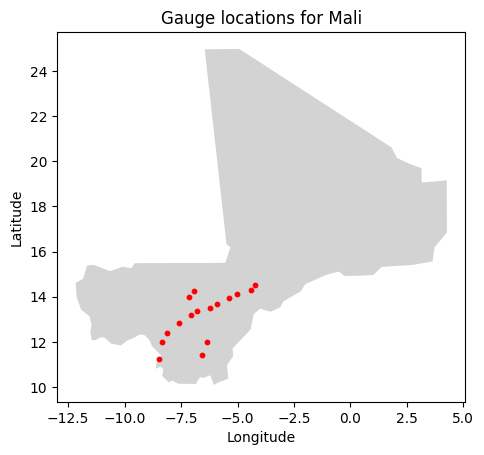

In [48]:
map_gauge_coordinates_of_country(df_gauges_ML, 'Mali')

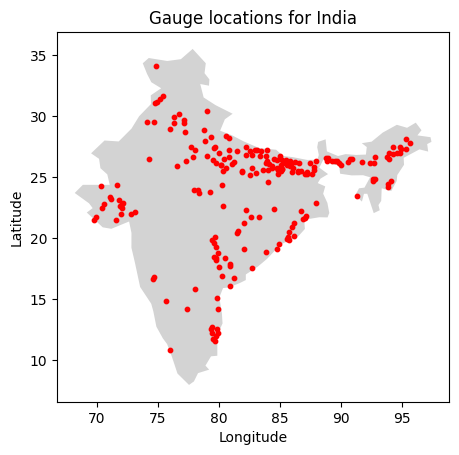

In [49]:
map_gauge_coordinates_of_country(
    get_ListGauges(
        dict_country_codes['India'], path_API_key
        ), 'India'
    )

In [50]:
from typing import List, Dict, Any
import requests
import pandas as pd

from get_key import get_API_key


def generate_url_GetGaugeModel(path_to_key : str) -> str:
    """
    Generate the URL to get the gauge model for a specific gauge

    :param path_to_key: path to the API key
    :return: the URL
    """
    
    # NEXT STEP: Kijk in voorbeeld Colab hoe ze het doen want de .pdf instructie klopt niet